In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from pong.pong import games_generator

import pickle

tf.enable_eager_execution()

/home/izpc/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/izpc/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/izpc/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/izpc/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

In [2]:
get_game = games_generator(40, 40, 256)

In [3]:
_, (frame, _) = next(get_game)

(40, 40)

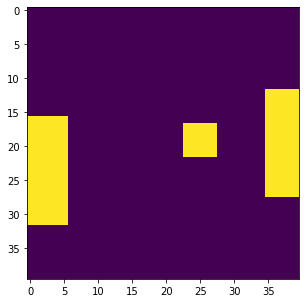

In [4]:
plt.figure(figsize=(5, 5))
plt.imshow(frame[120])
frame[120].shape

In [5]:
directions = []
controls = []
frames = []
done = []

for _ in tqdm(range(3000)):
    (d, c), (f, go) = next(get_game)
    directions.append(d)
    controls.append(c)
    frames.append(f)
    done.append(go)

directions = np.array(directions)
controls = np.array(controls)
frames = np.array(frames)
done = np.array(done)

directions.shape, controls.shape, frames.shape, done.shape

((3000,), (3000, 256, 2), (3000, 256, 40, 40), (3000, 256))

In [6]:
only_frames = frames.reshape((-1, 40, 40))
only_frames.shape

(768000, 40, 40)

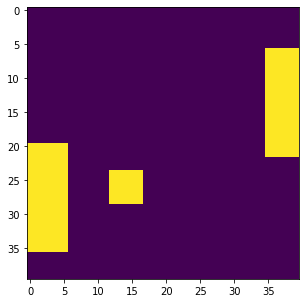

In [7]:
plt.figure(figsize=(5, 5))
plt.imshow(only_frames[120])

In [8]:
i = tf.keras.layers.Input((40, 40), name='input')
e = i
e = tf.keras.layers.Reshape((40, 40, 1))(e)
e = tf.keras.layers.Conv2D(32, (4, 4), activation='relu', strides=2)(e)
e = tf.keras.layers.Conv2D(64, (4, 4), activation='relu', strides=2)(e)
e = tf.keras.layers.Conv2D(128, (4, 4), activation='relu', strides=2)(e)
e = tf.keras.layers.Reshape((3 * 3 * 128,), name='flatten')(e)
e = tf.keras.layers.Dense(32)(e)

d = e
d = tf.keras.layers.Dense(1024)(d)
d = tf.keras.layers.Reshape((1, 1, 1024))(d)
d = tf.keras.layers.Conv2DTranspose(128, (4, 4), activation='relu', strides=2)(d)
d = tf.keras.layers.Conv2DTranspose(64, (5, 5), activation='relu', strides=1)(d)
d = tf.keras.layers.Conv2DTranspose(32, (5, 5), activation='relu', strides=2)(d)
d = tf.keras.layers.Conv2DTranspose(1, (4, 4), activation='relu', strides=2)(d)
d = tf.keras.layers.Reshape((40, 40), name='frame')(d)

net = tf.keras.Model(i, d)

net.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mse', 'accuracy']
)

In [16]:
encoder = tf.keras.Model(i, e)

In [123]:
decode_input = tf.keras.layers.Input((32,))
out = decode_input
for l in net.layers[7:]:
    out = l(out)
    
decoder = tf.keras.Model(decode_input, out)

In [9]:
net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 40, 40)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 19, 19, 32)        544       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         131200    
_________________________________________________________________
flatten (Reshape)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                36896 

In [10]:
net.fit(
    x=only_frames,
    y=only_frames,
    batch_size=128
)

768000/768000 [==============================] - 58s 75us/sample - loss: 0.0063 - mean_squared_error: 0.0063 - acc: 0.4591


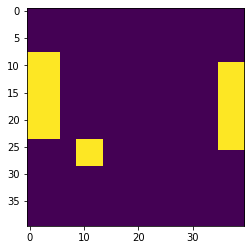

In [11]:
plt.imshow(only_frames[3000])

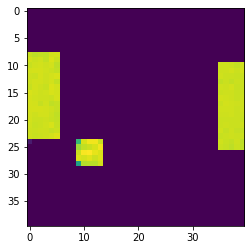

In [15]:
pred_f = net.predict(only_frames[3000].reshape(1, 40, 40)).reshape(40, 40)
plt.imshow(pred_f)

In [26]:
encoded_frames = []
for f in tqdm(frames):
    encoded_frames.append(encoder.predict(f))
        
encoded_frames = np.array(encoded_frames)
encoded_frames.shape

(3000, 256, 32)

In [52]:
init_dir = tf.keras.Input((1,))
dir_hidden = tf.keras.layers.Dense(256)(init_dir)
dir_cell_state = tf.keras.layers.Dense(256)(init_dir)

user_input = tf.keras.Input((None, 2))
prev_frame = tf.keras.Input((None, 32))
lstm_input = tf.keras.layers.Concatenate(axis=-1)([user_input, prev_frame])
lstm_input = tf.keras.layers.Dense(64)(lstm_input)

lstm = tf.keras.layers.LSTM(
    256,
    return_sequences=True
)(lstm_input, initial_state=[dir_hidden, dir_cell_state])

done_logits = tf.keras.layers.Dense(1)(lstm)
dense = tf.keras.layers.Dense(128)(lstm)
frame_logits = tf.keras.layers.Dense(32)(dense)

memory_net = tf.keras.Model([init_dir, user_input, prev_frame], [frame_logits, done_logits])

memory_net.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mse']
)

In [54]:
memory_net.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_62 (InputLayer)           [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
input_63 (InputLayer)           [(None, None, 32)]   0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, 34)     0           input_62[0][0]                   
                                                                 input_63[0][0]                   
__________________________________________________________________________________________________
input_61 (InputLayer)           [(None, 1)]          0                                      

In [91]:
memory_net.fit(
    x=[directions.reshape(-1, 1), controls[:, 1:], encoded_frames[:, 1:]],
    y=[encoded_frames[:, :-1], np.expand_dims(done[:, :-1], -1)],
    batch_size=128,
    epochs=10,
)

Epoch 1/10
3000/3000 [==============================] - 22s 7ms/sample - loss: 0.1149 - dense_80_loss: 0.1022 - dense_78_loss: 0.0115 - dense_80_mean_squared_error: 0.1033 - dense_78_mean_squared_error: 0.0116
Epoch 2/10
3000/3000 [==============================] - 22s 7ms/sample - loss: 0.0477 - dense_80_loss: 0.0405 - dense_78_loss: 0.0069 - dense_80_mean_squared_error: 0.0407 - dense_78_mean_squared_error: 0.0070
Epoch 3/10
3000/3000 [==============================] - 23s 8ms/sample - loss: 0.0310 - dense_80_loss: 0.0257 - dense_78_loss: 0.0052 - dense_80_mean_squared_error: 0.0257 - dense_78_mean_squared_error: 0.0052
Epoch 4/10
3000/3000 [==============================] - 23s 8ms/sample - loss: 0.0241 - dense_80_loss: 0.0197 - dense_78_loss: 0.0043 - dense_80_mean_squared_error: 0.0198 - dense_78_mean_squared_error: 0.0043
Epoch 5/10
3000/3000 [==============================] - 22s 7ms/sample - loss: 0.0204 - dense_80_loss: 0.0166 - dense_78_loss: 0.0038 - dense_80_mean_squared_er

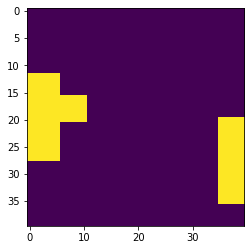

In [176]:
idx = 254
game_id = 3
plt.imshow(frames[game_id][idx])

In [180]:
pred_frames, pred_done = memory_net.predict(
    x=[
        directions.reshape(-1, 1)[game_id:game_id+1],
        controls[:, 1:][game_id:game_id+1],
        encoded_frames[:, 1:][game_id:game_id+1]
    ]
)

In [181]:
pred_frames[0][idx].reshape(1, -1).shape

(1, 32)

In [182]:
pred_image = decoder.predict(pred_frames[0][idx].reshape(1, -1))[0]

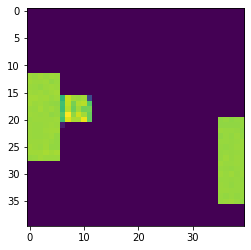

In [183]:
plt.imshow(pred_image)